# Exploring Class of Device
This notebook explores the class of device property of Bluetooth devices to try to isolate purely automobile observations relative to other modes (bike, ped, transit).

In [19]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [8]:
CONFIG = configparser.ConfigParser()
CONFIG.read('../../db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [18]:
sql = '''WITH total_cnt AS (SELECT sum(count) AS sum_total FROM rdumas.bt_cod_counts)

SELECT cod, device_type, to_char(sum(count), '999,999,999') AS "Number of observations",
to_char(100.0*sum(count)/sum_total, '99.9')||'%' AS "Proportion of Observations"
FROM rdumas.bt_cod_counts
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN total_cnt
GROUP BY cod, device_type, sum_total
ORDER BY sum(count) DESC
LIMIT 10'''
print_table(sql, con)

cod,device_type,Number of observations,Proportion of Observations
0,none,"105,355,516",43.4%
7995916,Smart phone,"45,302,122",18.7%
2098184,Hands-free Device,"31,757,060",13.1%
3408904,Hands-free Device,"14,333,013",5.9%
3146760,Hands-free Device,"7,517,161",3.1%
5898756,Cellular,"7,463,677",3.1%
5898764,Smart phone,"6,599,647",2.7%
5767684,Cellular,"3,734,775",1.5%
2360324,Wearable Headset Device,"3,324,702",1.4%
2360328,Hands-free Device,"1,842,918",.8%


`cod == 0` are WiFi devices. We're not entirely sure what they are, but I suspect strongly that they are smart phones with WiFi. [Because Bluetooth and WiFi addresses are different](https://stackoverflow.com/a/32732558/4047679) there's no way of knowing these are the same device (though an examination of timestamps and speeds could probably reveal this). So there may very likely be double-counting of smartphones that have Bluetooth and WiFi enabled.

Comparing the distribution of device types from the DVP and Adelaide

In [42]:
sql = pg.SQL('''
WITH total_cnt AS (
    SELECT start_road, sum(count) AS sum_total FROM rdumas.bt_cod_counts 
    INNER JOIN bluetooth.ref_segments USING (analysis_id)
    WHERE ARRAY[start_road::TEXT] <@ {road_names}
    GROUP BY start_road
) 
SELECT start_road AS "Route", device_type, 100.0*SUM(count)/sum_total AS "Proportion of Observations"
FROM rdumas.bt_cod_counts
INNER JOIN bluetooth.class_of_device USING (cod)
INNER JOIN bluetooth.ref_segments USING (analysis_id)
INNER JOIN total_cnt USING (start_road)
GROUP BY  "Route", device_type, sum_total
ORDER BY 100.0*SUM(count)/sum_total DESC
LIMIT 10''')

dvp_adelaide = pandasql.read_sql(sql.format(road_names = pg.Literal(['DVP','Adelaide'])), con)


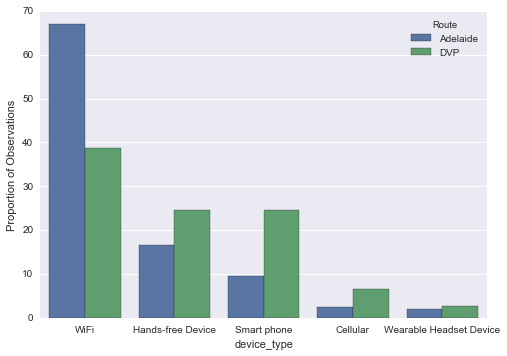

In [44]:
ax = sns.barplot(x='device_type', y="Proportion of Observations", hue='Route', data=dvp_adelaide)
ax.set_ylabel('Proportion of Observations')

The chart above shows a much greater proportion of WIFI devices on Adelaide --a major arterial with a protected bike-lane-- than on the DVP --a major expressway--. We can infer then that people travelling in non-car modes are more likely to have  WIFI devices enabled than a smart phone or cell phone with Bluetooth enabled. 